In [27]:
import geopandas as gpd
from shapely.ops import linemerge
from shapely.wkt import loads
from shapely.geometry import LineString

-----point file-----

In [45]:
df_point = gpd.read_file('hydrant_location/hydrant_location.shp')

In [46]:
df_point

,id,geometry
0,NaN,POINT (-74.00698 40.74748)
1,NaN,POINT (-74.00722 40.74722)
2,NaN,POINT (-74.00721 40.74697)
3,NaN,POINT (-74.00722 40.74722)
4,NaN,POINT (-74.00728 40.74667)
...,...,...
2295,NaN,POINT (-73.97976 40.71559)
2296,NaN,POINT (-73.97987 40.71361)
2297,NaN,POINT (-73.98387 40.72077)
2298,NaN,POINT (-73.97780 40.71833)


-----road file-----

In [17]:
df_road = gpd.read_file('road_location/road_location.shp')

In [19]:
df_road.drop('road_id', axis=1, inplace=True)

In [36]:
df_road

,id,geometry
0,1,"LINESTRING (-74.01301 40.70215, -74.01167 40.7..."
1,1,"LINESTRING (-74.01171 40.70247, -74.00999 40.7..."
2,1,"LINESTRING (-74.00577 40.70566, -74.00396 40.7..."
3,1,"LINESTRING (-74.00385 40.70651, -74.00142 40.7..."
4,2,"LINESTRING (-74.01270 40.70275, -74.01180 40.7..."
...,...,...
331,248,"LINESTRING (-73.99741 40.72164, -73.99389 40.7..."
332,249,"LINESTRING (-74.00203 40.71159, -74.00252 40.7..."
333,250,"LINESTRING (-74.00296 40.71334, -74.00150 40.7..."
334,251,"LINESTRING (-74.00799 40.70899, -74.00720 40.7..."


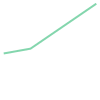

In [35]:
df_road.iloc[1][1]

In [33]:
merged_line_string = linemerge([df_road.iloc[1][1], df_road.iloc[0][1]])

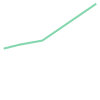

In [34]:
merged_line_string

In [39]:
def merge_linestrings(group):
    return linemerge(group.tolist())

In [41]:
merged_gdf_road= df_road.groupby('id')['geometry'].apply(merge_linestrings).reset_index()

In [43]:
merged_gdf_road

,id,geometry
0,1,"MULTILINESTRING ((-74.01301 40.70215, -74.0116..."
1,2,"MULTILINESTRING ((-74.01270 40.70275, -74.0118..."
2,3,"MULTILINESTRING ((-74.01274 40.70146, -74.0098..."
3,4,"LINESTRING (-74.00029 40.71119, -74.00045 40.7..."
4,5,"LINESTRING (-73.99137 40.72726, -73.99139 40.7..."
...,...,...
245,248,"LINESTRING (-73.99741 40.72164, -73.99389 40.7..."
246,249,"LINESTRING (-74.00203 40.71159, -74.00252 40.7..."
247,250,"LINESTRING (-74.00296 40.71334, -74.00150 40.7..."
248,251,"LINESTRING (-74.00799 40.70899, -74.00720 40.7..."
